In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import math
import time
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax)
from jax.experimental import optimizers


# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [2]:
import numpy as onp
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(context='poster', style='white',
        font='sans-serif', font_scale=1, color_codes=True, rc=None)

def generate_ou_process(batch_size, num_dims, mu, tau, sigma, noise_std, dt = 0.1):
    """ Ornstein-Uhlenbeck process sequences to train on """
    ou_x = onp.zeros((batch_size, num_dims))
    ou_x[:, 0] = onp.random.random(batch_size)
    for t in range(0, num_dims):
        dx = -(ou_x[:, t-1]-mu)/tau * dt + sigma*onp.sqrt(2/tau)*onp.random.normal(0, 1, batch_size)*onp.sqrt(dt)
        ou_x[:, t] =  ou_x[:, t-1] + dx

    ou_x_noise = ou_x + onp.random.multivariate_normal(onp.zeros(num_dims),
                                                        noise_std*onp.eye(num_dims),
                                                        batch_size)

    return ou_x, ou_x_noise


def plot_ou_process(x, x_tilde=None, x_pred=None,
                   title=r"Ornstein-Uhlenbeck Process"):
    """ Visualize an example datapoint (OU process or convolved noise)"""
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(range(len(x)), x, label="Ground Truth", alpha=0.75)
    if x_tilde is not None:
        ax.plot(range(len(x_tilde)), x_tilde, label="Noisy", alpha=0.75)
    if x_pred is not None:
        ax.plot(range(len(x_pred)), x_pred, label="Prediction")
    ax.set_ylabel(r"OU Process")
    ax.set_xlabel(r"Time $t$")
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=12)
    return


def plot_ou_loss(train_loss, title="Train Loss - OU GRU-RNN"):
    """ Visualize the learning performance of the OU process RNN """
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.plot(train_loss)
    ax.set_xlabel("# Batch Updates")
    ax.set_ylabel("Batch Loss")
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


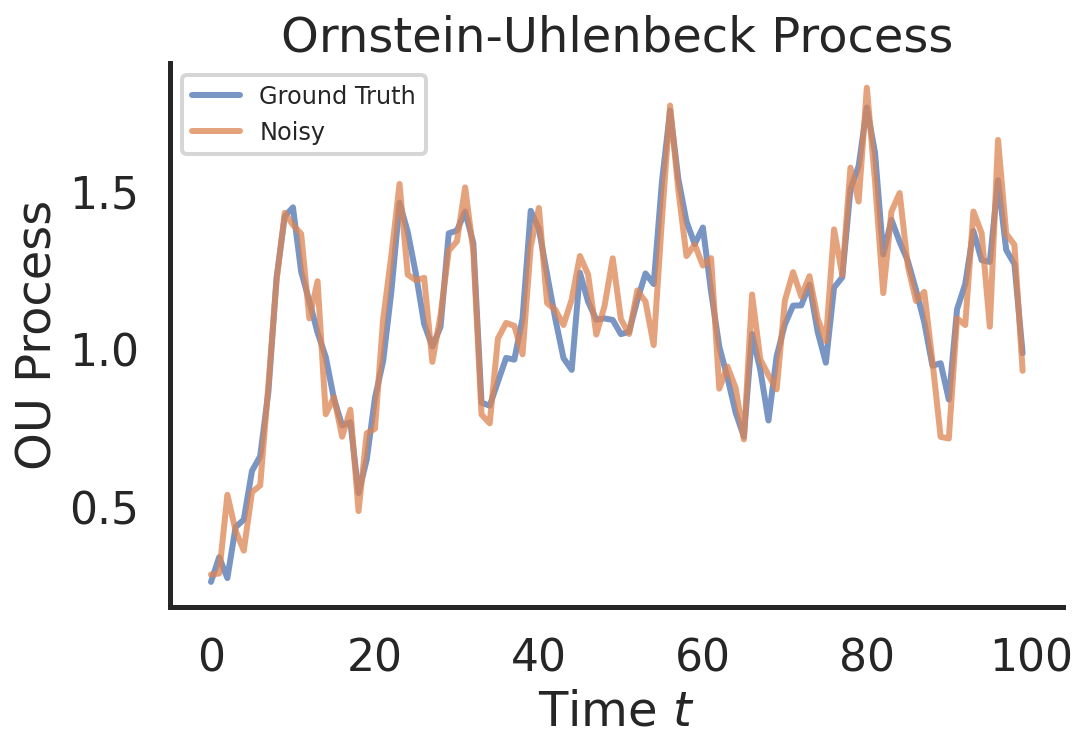

In [3]:
# Generate & plot a time series generated by the OU process
x_0, mu, tau, sigma, dt = 0, 1, 2, 0.5, 0.1
noise_std = 0.01
num_dims, batch_size = 100, 64  # Number of timesteps in process

x, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau,
                                 sigma, noise_std, dt)
plot_ou_process(x[0, :], x_tilde[0, :])


In [0]:
from jax.nn import sigmoid
from jax.nn.initializers import glorot_normal, normal

from functools import partial
from jax import lax

def GRU(out_dim, W_init=glorot_normal(), b_init=normal()):
    def init_fun(rng, input_shape):
        """ Initialize the GRU layer for stax """
        hidden = b_init(rng, (input_shape[0], out_dim))

        k1, k2, k3 = random.split(rng, num=3)
        update_W, update_U, update_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        reset_W, reset_U, reset_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        out_W, out_U, out_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)
        # Input dim 0 represents the batch dimension
        # Input dim 1 represents the time dimension (before scan moveaxis)
        output_shape = (input_shape[0], input_shape[1], out_dim)
        return (output_shape,
            (hidden,
             (update_W, update_U, update_b),
             (reset_W, reset_U, reset_b),
             (out_W, out_U, out_b),),)

    def apply_fun(params, inputs, **kwargs):
        """ Loop over the time steps of the input sequence """
        h = params[0]
        
        def apply_fun_scan(params, hidden, inp):
            """ Perform single step update of the network """
            _, (update_W, update_U, update_b), (reset_W, reset_U, reset_b), (
                out_W, out_U, out_b) = params


            update_gate = sigmoid(np.dot(inp, update_W) +np.dot(hidden, update_U) + update_b)
            reset_gate = sigmoid(np.dot(inp, reset_W) +np.dot(hidden, reset_U) + reset_b)
            output_gate = np.tanh(np.dot(inp, out_W)+ np.dot(np.multiply(reset_gate, hidden), out_U)+ out_b)
            return hidden, output_gate

        # Move the time dimension to position 0 so lax.scan can loop over time
        inputs = np.moveaxis(inputs, 1, 0)
        f = partial(apply_fun_scan, params)
        _, out = lax.scan(f, h, inputs)
        return out

    return init_fun, apply_fun

In [0]:
num_dims = 100              # Number of OU timesteps
batch_size = 64            # Batchsize
num_hidden_units = 12      # GRU cells in the RNN layer 

# Initialize the network and perform a forward pass
init_fun, gru_rnn = stax.serial(Dense(num_hidden_units), Relu,
                                GRU(num_hidden_units), Dense(1))
_, params = init_fun(key, (batch_size, num_dims, 1))

def mse_loss(params, inputs, targets):
    """ Calculate the Mean Squared Error Prediction Loss. """
    preds = gru_rnn(params, inputs)
    return np.mean((preds - targets)**2)

@jit
def update(params, x, y, opt_state):
    """ Perform a forward pass, calculate the MSE & perform a SGD step. """
    loss, grads = value_and_grad(mse_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, loss

**Training the RNN**

In [6]:
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)


opt_state = opt_init(params)
num_batches = 1500
train_loss_log = []
start_time = time.time()

for batch_idx in range(num_batches):
    x, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau, sigma, noise_std)
    x_in = x_tilde[:, :(num_dims-1)]
    y = x[:, 1:]
    y = np.array(y)
    x_in = np.expand_dims(x_in, 2)
    params, opt_state, loss = update(params, x_in, y, opt_state)
    batch_time = time.time() - start_time
    train_loss_log.append(loss)

    if batch_idx % 100 == 0:
        start_time = time.time()
        print("Batch {} | T: {:0.2f} | MSE: {:0.2f} |".format(batch_idx, batch_time, loss))

Batch 0 | T: 1.97 | MSE: 0.74 |
Batch 100 | T: 3.05 | MSE: 0.44 |
Batch 200 | T: 3.03 | MSE: 0.33 |
Batch 300 | T: 3.04 | MSE: 0.31 |
Batch 400 | T: 3.04 | MSE: 0.31 |
Batch 500 | T: 3.01 | MSE: 0.28 |
Batch 600 | T: 3.09 | MSE: 0.29 |
Batch 700 | T: 3.06 | MSE: 0.28 |
Batch 800 | T: 2.99 | MSE: 0.27 |
Batch 900 | T: 3.00 | MSE: 0.31 |
Batch 1000 | T: 3.04 | MSE: 0.26 |
Batch 1100 | T: 3.00 | MSE: 0.28 |
Batch 1200 | T: 2.96 | MSE: 0.27 |
Batch 1300 | T: 3.00 | MSE: 0.31 |
Batch 1400 | T: 3.00 | MSE: 0.27 |


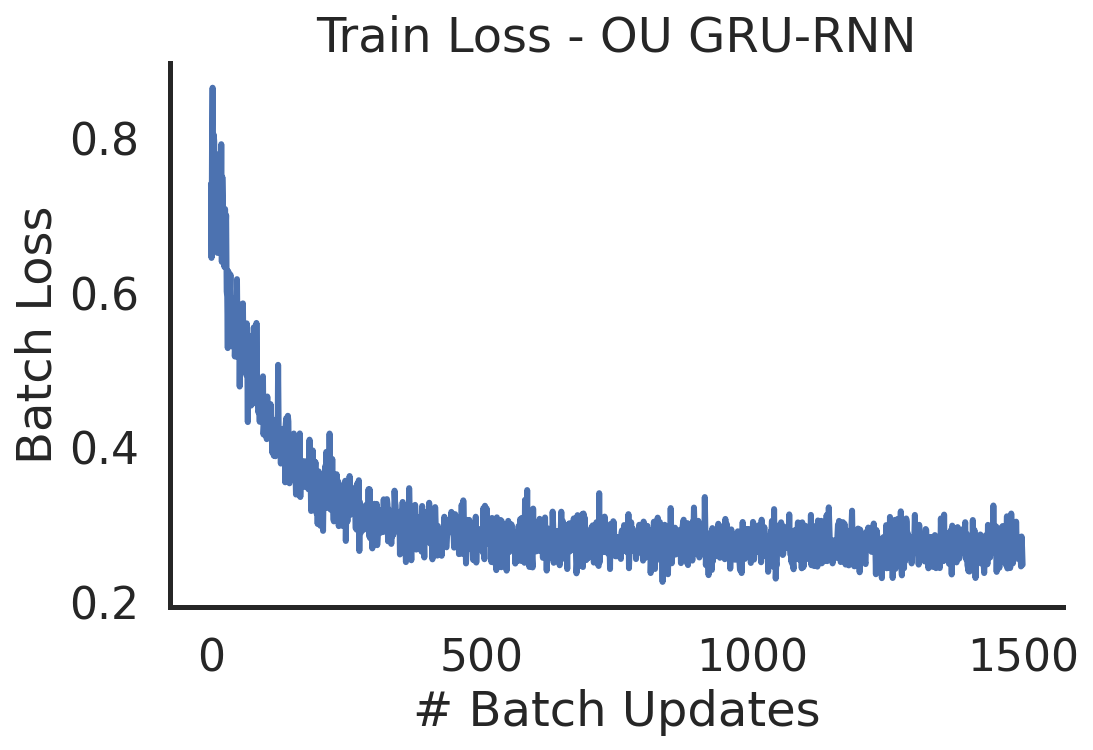

In [7]:
plot_ou_loss(train_loss_log)

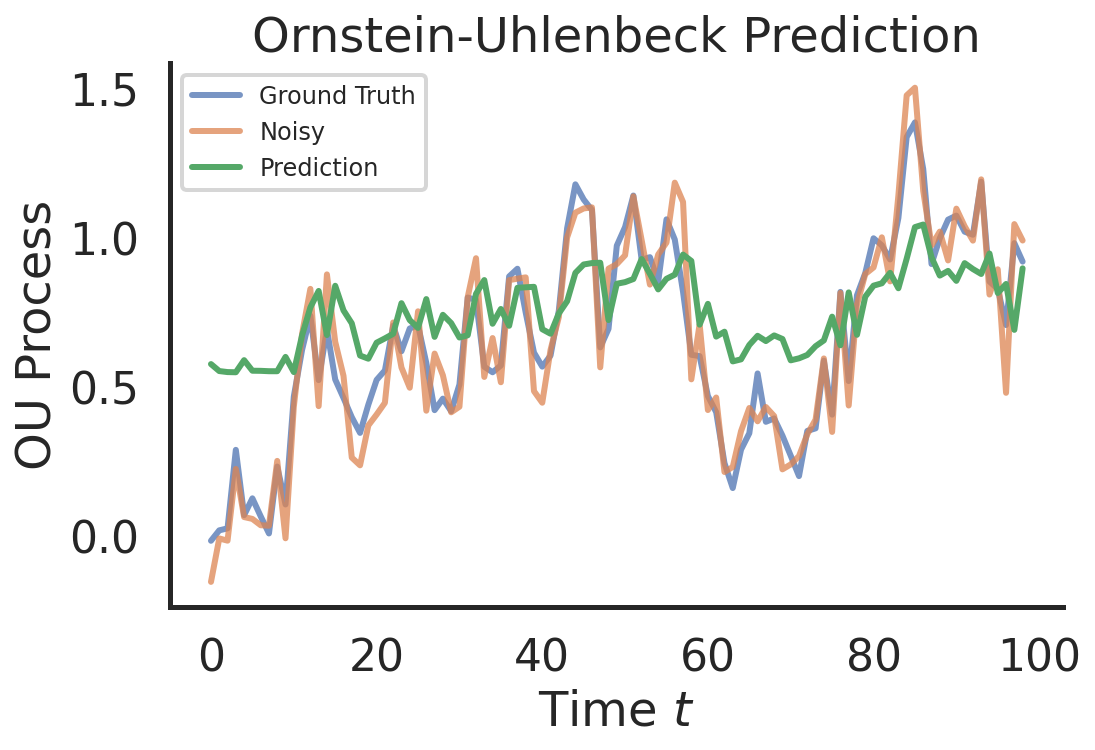

In [8]:
# Plot a prediction and ground truth OU process
x_true, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau, sigma, noise_std)
x_in = x_tilde[:, :(num_dims-1)]
y = x[:, 1:]
y = np.array(y)
x_in = np.expand_dims(x_in, 2)
preds = gru_rnn(params, x_in)

y = onp.array(y)
x_true = onp.array(x_true)
x_pred = onp.array(preds)
plot_ou_process(x_true[0, 1:], x_tilde=x_tilde[0, 1:], x_pred=x_pred[:, 0],
               title=r"Ornstein-Uhlenbeck Prediction")

From the plot above, the difference between
the predicted time series, the ground truth, and the noisy time series is that predictied time series is more smooth than the other two. The predicted line seems to lie in with range  mean $\mu = 0.5$ to $\mu = 1$  which can be considered as desired behavior.